<a href="https://colab.research.google.com/github/Coldman22/Coldman22.Calibration/blob/main/Comparison_of_Calibration_of_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparison of Calibration of Classifiers

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [2]:
X, y = make_classification(
    n_samples=100_000, n_features=20, n_informative=2, n_redundant=2, random_state=42
)

In [3]:
train_samples = 100  # Samples used for training the models
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=100_000 - train_samples,
)

## Calibration curves

In [4]:
import numpy as np
from sklearn.svm import LinearSVC

In [5]:
class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0,1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

In [6]:
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [7]:
# Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = NaivelyCalibratedLinearSVC(C=1.0)
rfc = RandomForestClassifier()

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (svc, "SVC"),
    (rfc, "Random forest"),
]

Text(0.5, 1.0, 'Calibration plots')

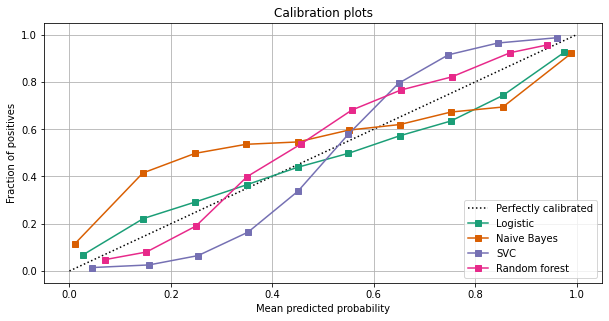

In [8]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

In [12]:
# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


<Figure size 432x288 with 0 Axes>

LogisticRegression returns well calibrated predictions as it directly optimizes log-loss. In contrast, the other methods return biased probabilities, with different biases for each method:

GaussianNB tends to push probabilities to 0 or 1 (see histogram). This is mainly because the naive Bayes equation only provides correct estimate of probabilities when the assumption that features are conditionally independent holds 2. However, features tend to be positively correlated and is the case with this dataset, which contains 2 features generated as random linear combinations of the informative features. These correlated features are effectively being ‘counted twice’, resulting in pushing the predicted probabilities towards 0 and 1 3.

RandomForestClassifier shows the opposite behavior: the histograms show peaks at approx. 0.2 and 0.9 probability, while probabilities close to 0 or 1 are very rare. An explanation for this is given by Niculescu-Mizil and Caruana 1: “Methods such as bagging and random forests that average predictions from a base set of models can have difficulty making predictions near 0 and 1 because variance in the underlying base models will bias predictions that should be near zero or one away from these values. Because predictions are restricted to the interval [0,1], errors caused by variance tend to be one- sided near zero and one. For example, if a model should predict p = 0 for a case, the only way bagging can achieve this is if all bagged trees predict zero. If we add noise to the trees that bagging is averaging over, this noise will cause some trees to predict values larger than 0 for this case, thus moving the average prediction of the bagged ensemble away from 0. We observe this effect most strongly with random forests because the base-level trees trained with random forests have relatively high variance due to feature subsetting.” As a result, the calibration curve shows a characteristic sigmoid shape, indicating that the classifier is under-confident and could return probabilities closer to 0 or 1.

To show the performance of LinearSVC, we naively scale the output of the decision_function into [0, 1] by applying min-max scaling, since SVC does not output probabilities by default. LinearSVC shows an even more sigmoid curve than the RandomForestClassifier, which is typical for maximum-margin methods 1 as they focus on difficult to classify samples that are close to the decision boundary (the support vectors).